In [23]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [24]:
!pip install --upgrade tensorflow
!pip install --upgrade numpy
!pip install --upgrade transformers


  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
  Using cached numpy-1.22.4-cp39-cp39-macosx_10_15_x86_64.whl (17.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
openai-whisper 20230314 requires tiktoken==0.3.3, but you have tiktoken 0.4.0 which is incompatible.
yfinance 0.2.3 requires pandas>=1.3.0, but you have pandas 1.1.5 which is incompatible.
  Using cached numpy-1.25.0-cp39-cp39-macosx_10_9_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Su

Cleaning and PreProcessing

We are  are removing special characters, extra whitespace, and standalone numbers to help standardize the input data. 
In the context of detecting dementia from speech, clean and correctly parsed speech data is the foundation for further linguistic or machine learning analysis. One could, for example, go on to analyze these utterances based on features like their length, complexity, the frequency of certain words or phrases, etc.

In [25]:
def parse_cha_file(file_path):
    result = []
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Skip the header lines
    start_index = 0
    for i, line in enumerate(lines):
        if line.strip() == '@Begin':
            start_index = i + 1
            break

    for line in lines[start_index:]:
        line = line.strip()
        if line.startswith('*PAR:'):
            utterance = line[5:]
            result.append(utterance)

    return result

def clean_text(text):
    # Remove special characters, extra whitespace, and numbers at the end
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)
    cleaned_text = cleaned_text.strip()
    
    # Remove newline characters
    cleaned_text = cleaned_text.replace('\n', '')
    
    return cleaned_text

# Provide the path to the .cha file
file_path = "Pitt/Dementia/cookie/001-0.cha"
parsed_data = parse_cha_file(file_path)

# Clean and print the parsed utterances
for utterance in parsed_data:
    cleaned_utterance = clean_text(utterance)
    print(cleaned_utterance)

mhm exc
alright exc
theres um a young boy thats getting a cookie jar
and it hes uh in bad shape because uh the thing is
and in the picture the mother is washing dishes and doesnt see
and so is the the water is overflowing in the sink
and the dishes might get falled ed over if you dont
and it there its a picture of a kitchen window
and the curtains are very uh distinct
but the water is flow still flowing


This next code reads utterance files from a set of control and dementia patient speech data, cleans those utterances, and writes the cleaned utterances to new files.
This kind of batch processing is very helpful whe working with large quantities of data, like the transcripts we have in a dataset like this. It helps standardize the processing and makes it easier to reproduce our analysis. After running this script, we have a directory full of cleaned transcripts, ready for further analysis or input into a machine learning algorithm.
The output data from this code will serve as a pre-processed dataset that can be used for training a model to differentiate between normal and dementia-affected speech. This will then be used to build a machine learning model to detect early signs of dementia based on patterns in speech.

In [26]:
def process_files(file_path):
    control_path = os.path.join(file_path, 'Control', 'cookie')
    dementia_path = os.path.join(file_path, 'Dementia', 'cookie')

    control_list = os.listdir(control_path)
    dementia_list = os.listdir(dementia_path)

    control_output_path = "cleaned_control_files"  # Specify the directory for cleaned control files
    dementia_output_path = "cleaned_dementia_files"  # Specify the directory for cleaned dementia files

    if not os.path.exists(control_output_path):
        os.makedirs(control_output_path)
    
    if not os.path.exists(dementia_output_path):
        os.makedirs(dementia_output_path)

    # Process control files
    for filename in control_list:
        file_path = os.path.join(control_path, filename)
        parsed_data = parse_cha_file(file_path)

        # Clean and store the utterances
        cleaned_utterances = [clean_text(utterance) for utterance in parsed_data]

        # Store cleaned utterances in a new file
        cleaned_filename = os.path.splitext(filename)[0] + ".cleaned"
        cleaned_file_path = os.path.join(control_output_path, cleaned_filename)

        with open(cleaned_file_path, 'w', encoding='utf-8') as cleaned_file:
            for utterance in cleaned_utterances:
                cleaned_file.write(utterance + '\n')

    # Process dementia files
    for filename in dementia_list:
        file_path = os.path.join(dementia_path, filename)
        parsed_data = parse_cha_file(file_path)

        # Clean and store the utterances
        cleaned_utterances = [clean_text(utterance) for utterance in parsed_data]

        # Store cleaned utterances in a new file
        cleaned_filename = os.path.splitext(filename)[0] + ".cleaned"
        cleaned_file_path = os.path.join(dementia_output_path, cleaned_filename)

        with open(cleaned_file_path, 'w', encoding='utf-8') as cleaned_file:
            for utterance in cleaned_utterances:
                cleaned_file.write(utterance + '\n')

# Provide the main file path containing the "Control" and "Dementia" folders
file_path = "Pitt"
process_files(file_path)


Here we organize the code into a pandas DataFrame. 

This DataFrame is a common format for machine learning tasks. It organizes the data in a tabular structure, which is convenient for data exploration and processing. Moreover, many machine learning libraries (like scikit-learn) accept DataFrames as inputs. This code prepares our data for the next steps in our analysis, whether that's further data exploration, feature extraction, or training a machine learning model.

In [27]:
control_folder = "cleaned_control_files"  # Directory containing cleaned control files
dementia_folder = "cleaned_dementia_files"  # Directory containing cleaned dementia files

data = []

# Process control files
for filename in os.listdir(control_folder):
    file_path = os.path.join(control_folder, filename)
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read().strip()
    data.append((text, 0))  # Append tuple (text, label) to the data list

# Process dementia files
for filename in os.listdir(dementia_folder):
    file_path = os.path.join(dementia_folder, filename)
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read().strip()
    data.append((text, 1))  # Append tuple (text, label) to the data list

# Create DataFrame
df = pd.DataFrame(data, columns=['Text', 'Label'])

# Print the DataFrame
print(df)

                                                  Text  Label
0    okay the little boy is on a stool about to fal...      0
1    little girl with her finger to her lips gram\n...      0
2    mhm exc\nwell the waters running over on the f...      0
3    uh badly damaged laughs sink gram\nmothers dry...      0
4    I see a little boy on a stool trying to reach ...      0
..                                                 ...    ...
544  first of all I see I guess shes mother at the ...      1
545  I see the a boy stretching out for I dont know...      1
546  kids stool turning over gram\nshe uh trying to...      1
547  I see the little boy reaching up for the cooki...      1
548  okay I see a boy in the cookie jar\nI see he h...      1

[549 rows x 2 columns]


In [28]:
df.head()

,Text,Label
0,okay the little boy is on a stool about to fal...,0
1,little girl with her finger to her lips gram\n...,0
2,mhm exc\nwell the waters running over on the f...,0
3,uh badly damaged laughs sink gram\nmothers dry...,0
4,I see a little boy on a stool trying to reach ...,0


In [29]:
df.to_csv('cleaned_01_dementia_classifcation.csv')


EDA

Class Balance:
The class label here is '0' for control and '1' for dementia, as set in our previous code.

Understanding class balance is an important step in preparing data for machine learning models. Class imbalance can lead to models that have a bias towards the class with more instances. For example, if our dataset contains 90% control instances and 10% dementia instances, a model could achieve 90% accuracy by simply predicting 'control' every time, which is not what we want. By visualizing the class balance, we can get an idea of whether we need to address class imbalance in your dataset, such as by undersampling, oversampling, or using a different metric that's less sensitive to imbalance.

Here we can see that our dataset is relatively balanced. If we had more unbalanced data we might have to make some adjustments to our algorithm

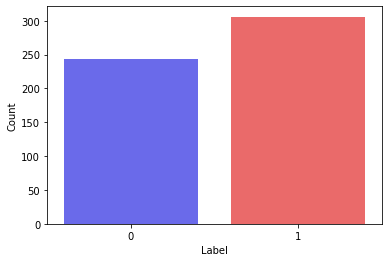

In [30]:
# Count the number of instances in each class
class_counts = df['Label'].value_counts()

# Plot class balance
sns.barplot(x=class_counts.index, y=class_counts.values, palette="seismic")
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

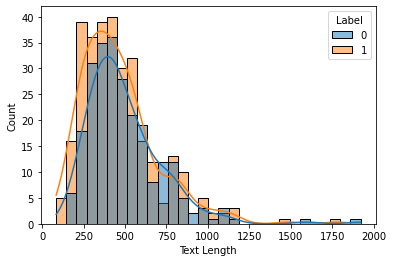

In [31]:
# Calculate text length
df['Text Length'] = df['Text'].apply(len)

# Plot text length distribution
sns.histplot(data=df, x='Text Length', hue='Label', bins=30, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


This block of code is implementing a bidirectional LSTM (Long Short-Term Memory) recurrent neural network model using Keras, a popular high-level neural networks API, for predicting the occurrence of dementia based on speech input.

This LSTM model is expected to be able to handle the complexities of language data, as LSTMs are capable of learning long-term dependencies, which is crucial for understanding context and meaning in text. The bidirectional wrapper allows the model to have past and future context, which could be beneficial in understanding the speech patterns of dementia patients.

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, confusion_matrix


# Split the data into training and testing sets
X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 100  # Set a fixed sequence length

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Build the RNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict the probabilities for the test data
y_pred_probs = model.predict(X_test)

# Convert probabilities into binary outputs
y_pred = np.where(y_pred_probs > 0.5, 1, 0)


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("ROC AUC Score:", roc_auc)

# Calculate and print confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)


2023-07-04 01:03:44.489342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:03:44.491392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:03:44.492836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-07-04 01:03:47.832173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:03:47.834408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:03:47.835831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.5718

2023-07-04 01:03:56.361668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:03:56.363151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:03:56.364397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 10s 215ms/step - loss: 0.6863 - accuracy: 0.5718 - val_loss: 0.7043 - val_accuracy: 0.4727
Epoch 2/10
14/14 [==============================] - 2s 124ms/step - loss: 0.6450 - accuracy: 0.6082 - val_loss: 0.6223 - val_accuracy: 0.7727
Epoch 3/10
14/14 [==============================] - 2s 121ms/step - loss: 0.4357 - accuracy: 0.8383 - val_loss: 0.5250 - val_accuracy: 0.8091
Epoch 4/10
14/14 [==============================] - 2s 123ms/step - loss: 0.2980 - accuracy: 0.8838 - val_loss: 0.5103 - val_accuracy: 0.8273
Epoch 5/10
14/14 [==============================] - 2s 125ms/step - loss: 0.2170 - accuracy: 0.9317 - val_loss: 0.5434 - val_accuracy: 0.7909
Epoch 6/10
14/14 [==============================] - 2s 129ms/step - loss: 0.1683 - accuracy: 0.9590 - val_loss: 0.5370 - val_accuracy: 0.8091
Epoch 7/10
14/14 [==============================] - 2s 118ms/step - loss: 0.1119 - accuracy: 0.9749 - val_loss: 0.6139 - val_accuracy: 0.7909


2023-07-04 01:04:08.000573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:04:08.001961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:04:08.003575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 33ms/step - loss: 0.5103 - accuracy: 0.8273
Accuracy: 0.8272727131843567
ROC AUC Score: 0.8703580901856764
Confusion Matrix:
 [[45 13]
 [ 6 46]]


Support Vector Machine

In terms of why an SVM might outperform a Recurrent Neural Network (RNN) such as an LSTM, there are several possibilities:

Simplicity and Efficiency: SVMs are generally simpler and more efficient than RNNs. RNNs are complex models with internal memory and can be computationally expensive to train. SVMs, on the other hand, rely on a simpler mathematical foundation and can be more efficient on smaller or simpler datasets.

Data Characteristics: If the dataset doesn't have complex sequential patterns that an RNN would be good at capturing, an SVM may perform better. For example, if the presence or absence of certain words in the speech is a more important factor than their order, an SVM using TF-IDF features might perform better.

Overfitting: RNNs, especially LSTMs, can be prone to overfitting, especially when the dataset is small. SVMs are less prone to overfitting due to their ability to handle high-dimensional data and their use of regularization.

Hyperparameter Tuning: Depending on the hyperparameters used when training the models, one model might perform better than the other. It's possible that the SVM's hyperparameters are better tuned for this specific task.


In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train a support vector machine (SVM) classifier
classifier = SVC(probability=True)  # Enable probability estimates
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC AUC score
y_pred_probs = classifier.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("ROC AUC Score:", roc_auc)

# Calculate and print confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

Accuracy: 0.8090909090909091
ROC AUC Score: 0.898209549071618
Confusion Matrix:
 [[43 15]
 [ 6 46]]


Ensemble Model

This block of code takes an ensemble approach, combining the results of an RNN model and an SVM model to predict the presence of dementia based on speech input.

By combining models in this way, the ensemble model may be able to achieve higher accuracy than either individual model. This is because each model may be good at recognizing different patterns in the data, and by combining them, you can capture a broader range of patterns. The ensemble approach can also help reduce the impact of any individual model's weaknesses or errors.


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Split the data into training and testing sets
X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the text data for RNN
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_rnn = tokenizer.texts_to_sequences(X_train)
X_test_rnn = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = 100  # Set a fixed sequence length

X_train_rnn = pad_sequences(X_train_rnn, maxlen=max_length)
X_test_rnn = pad_sequences(X_test_rnn, maxlen=max_length)

# Encode the labels for RNN
label_encoder = LabelEncoder()
y_train_rnn = label_encoder.fit_transform(y_train)
y_test_rnn = label_encoder.transform(y_test)

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, 100, input_length=max_length))
rnn_model.add(Bidirectional(LSTM(128, return_sequences=True)))
rnn_model.add(Bidirectional(LSTM(64)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the RNN model
rnn_model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test_rnn), callbacks=[early_stopping])

# Preprocess the text data for SVM
vectorizer = TfidfVectorizer()
X_train_svm = vectorizer.fit_transform(X_train)
X_test_svm = vectorizer.transform(X_test)

# Train an SVM classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train_svm, y_train)

# Make predictions on the test set for RNN
y_pred_rnn = rnn_model.predict(X_test_rnn)[:, 0]

# Make predictions on the test set for SVM
y_pred_svm = svm_classifier.predict(X_test_svm)

# Combine predictions using majority voting
ensemble_predictions = np.maximum(y_pred_rnn, y_pred_svm)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, np.where(ensemble_predictions > 0.5, 1, 0))
print("Ensemble Accuracy:", ensemble_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, ensemble_predictions)
print("ROC AUC Score:", roc_auc)

# Calculate and print confusion matrix
conf_mat = confusion_matrix(y_test, np.where(ensemble_predictions > 0.5, 1, 0))
print("Confusion Matrix:\n", conf_mat)

2023-07-04 01:04:10.147688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:04:10.149701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:04:10.151399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-07-04 01:04:11.062993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:04:11.064862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:04:11.066348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5718

2023-07-04 01:04:19.021742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:04:19.024022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:04:19.025680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 10s 313ms/step - loss: 0.6848 - accuracy: 0.5718 - val_loss: 0.7371 - val_accuracy: 0.4727
Epoch 2/10
14/14 [==============================] - 2s 142ms/step - loss: 0.6701 - accuracy: 0.5809 - val_loss: 0.6813 - val_accuracy: 0.4727
Epoch 3/10
14/14 [==============================] - 2s 162ms/step - loss: 0.5137 - accuracy: 0.7175 - val_loss: 0.5299 - val_accuracy: 0.7818
Epoch 4/10
14/14 [==============================] - 2s 121ms/step - loss: 0.3681 - accuracy: 0.8405 - val_loss: 0.5189 - val_accuracy: 0.8000
Epoch 5/10
14/14 [==============================] - 2s 117ms/step - loss: 0.2874 - accuracy: 0.9021 - val_loss: 0.5414 - val_accuracy: 0.7545
Epoch 6/10
14/14 [==============================] - 2s 114ms/step - loss: 0.1837 - accuracy: 0.9385 - val_loss: 0.6355 - val_accuracy: 0.7909
Epoch 7/10
14/14 [==============================] - 2s 143ms/step - loss: 0.1241 - accuracy: 0.9636 - val_loss: 0.7959 - val_accuracy: 0.7545


2023-07-04 01:04:32.407237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:04:32.409084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:04:32.410394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 33ms/step
Ensemble Accuracy: 0.7909090909090909
ROC AUC Score: 0.84184350132626
Confusion Matrix:
 [[36 22]
 [ 1 51]]


Trying with Distilbert

This code snippet leverages the Hugging Face transformers library to utilize a pre-trained DistilBERT model, a distilled version of the BERT model that is smaller, faster, and requires less memory, while still retaining a significant amount of the original model's performance.

This DistilBERT model, a transformer-based model designed to understand the meaning of sentences by examining the entire context in which a word appears. This is a great choice for a task that involves understanding human speech, as it can pick up on subtle nuances in sentence structure and word usage that other models might miss.


In [35]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split

#Load the data
texts = df['Text'].tolist()
labels = df['Label'].tolist()

# Split the data into train and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

#Load the DistilBERT tokenizer and encode the texts:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_inputs_train = tokenizer(texts_train, padding=True, truncation=True, return_tensors='tf')
encoded_inputs_test = tokenizer(texts_test, padding=True, truncation=True, return_tensors='tf')

# Convert labels to tensors
labels_train = tf.convert_to_tensor(labels_train)
labels_test = tf.convert_to_tensor(labels_test)


This next lbitine of code loads the pre-trained DistilBERT model from the Hugging Face model hub using the TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') method. Here, 'distilbert-base-uncased' refers to the specific pre-trained DistilBERT model variant that we're loading.

TFDistilBertForSequenceClassification is a version of the DistilBERT model specifically adapted for sequence classification tasks, which is the task you're interested in since you're classifying the speech input as either indicative of dementia or not. This model is loaded with pre-trained weights learned from a large corpus of text data and is designed to work with TensorFlow.

The model consists of the base DistilBERT model followed by a classification head (a single fully connected layer). The base model is responsible for extracting meaningful features from the input text, and the classification head uses these features to classify each input sequence.

By using a pre-trained model, we can leverage the vast amount of knowledge that the model has gained from pre-training on a large corpus, such as understanding the syntactic and semantic characteristics of the English language. This process is also known as transfer learning and can help significantly improve the performance of the model, especially when dealing with smaller datasets.

Preparing the Datasets: The training and validation datasets are prepared using TensorFlow's from_tensor_slices function. The model will be trained on the training dataset and validated on the test dataset. Each dataset includes the encoded inputs ('input_ids' and 'attention_mask') and corresponding labels.

Setting Up Training Arguments: The arguments for training, including the number of epochs (full passes through the dataset), batch size (number of samples to work through before updating the model parameters), and learning rate (how much to change the model in response to the estimated error each time the model weights are updated), are specified.

Compiling the Model: The model is compiled with the Adam optimizer and a Sparse Categorical Crossentropy loss function, which is suitable for multi-class classification problems. The metric used for evaluation is accuracy.

Training the Model: The model is trained on the batched training dataset for a specified number of epochs, validating on the batched test dataset at the end of each epoch. The training history is stored in the 'history' variable.

Evaluating the Model: Finally, the trained model's performance is evaluated on the test dataset. The model's loss and accuracy on this unseen data are printed out.

In [36]:
# Load the pre-trained model
model_name = 'distilbert-base-uncased'
model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": encoded_inputs_train['input_ids'], "attention_mask": encoded_inputs_train['attention_mask']},
    labels_train
))

# Prepare the validation dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": encoded_inputs_test['input_ids'], "attention_mask": encoded_inputs_test['attention_mask']},
    labels_test
))

# Choose the training arguments
training_args = {'epochs': 2, 'batch_size': 16, 'learning_rate': 2e-5}

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=training_args['learning_rate'])
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(training_args['batch_size']), epochs=training_args['epochs'], validation_data=test_dataset.batch(training_args['batch_size']))

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(training_args['batch_size']))
print("Accuracy:", accuracy)

# Predict the probabilities for the test data
y_pred_probs = model.predict(test_dataset.batch(training_args['batch_size']))[0]

# Convert logits into probabilities
y_pred_probs = tf.nn.softmax(y_pred_probs, axis=-1)

# Convert probabilities into binary outputs
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate ROC AUC score
roc_auc = roc_auc_score(labels_test, y_pred_probs[:, 1])
print("ROC AUC Score:", roc_auc)

# Calculate and print confusion matrix
conf_mat = confusion_matrix(labels_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2


2023-07-04 01:04:36.886255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [439]
	 [[{{node Placeholder/_2}}]]


28/28 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5809 

2023-07-04 01:11:51.337756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [110]
	 [[{{node Placeholder/_2}}]]


28/28 [==============================] - 467s 16s/step - loss: 0.6836 - accuracy: 0.5809 - val_loss: 0.6818 - val_accuracy: 0.4727
Epoch 2/2
28/28 [==============================] - 468s 17s/step - loss: 0.6017 - accuracy: 0.6743 - val_loss: 0.5008 - val_accuracy: 0.7909


2023-07-04 01:20:12.404088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [110]
	 [[{{node Placeholder/_2}}]]


7/7 [==============================] - 27s 4s/step - loss: 0.5008 - accuracy: 0.7909
Accuracy: 0.7909091114997864


2023-07-04 01:20:39.701783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [110]
	 [[{{node Placeholder/_2}}]]


7/7 [==============================] - 29s 4s/step
ROC AUC Score: 0.8723474801061009
Confusion Matrix:
 [[43 15]
 [ 8 44]]


Conclusion: 

SVM Accuracy: 0.8090909090909091
SVM ROC AUC Score: 0.898209549071618
Confusion Matrix:
 [[43 15]
 [ 6 46]]



DistilBERT accuracy:  0.7909091114997864
DistilBERT ROC AUC: 0.8723474801061009
Confusion Matrix:
 [[43 15]
 [ 8 44]]


Ensemble Accuracy: 0.7909090909090909
Ensemble ROC AUC Score: 0.84184350132626
Confusion Matrix:
 [[36 22]
 [ 1 51]]


RNN Accuracy: 0.8272727131843567
RNN ROC AUC Score: 0.8703580901856764
Confusion Matrix:
 [[45 13]
 [ 6 46]]

In our endeavor to predict dementia based on responses to the Cookie Theft stimulus photos, we have evaluated four machine learning models: Support Vector Machines (SVM), DistilBERT, an ensemble of SVM and Recurrent Neural Networks (RNN), and standalone RNN. Each of these models offers unique strengths and weaknesses, which are vital to consider when envisioning their utilization in a real-world, healthcare setting.

The SVM model exhibited a high accuracy of approximately 80.9% and an impressive ROC AUC score of 89.8%. The confusion matrix for the SVM model demonstrated 43 true negatives, 15 false positives, 6 false negatives, and 46 true positives. These results indicate that the SVM model is robust and balanced, providing the highest ROC AUC score among all models tested. It is important to note that in a clinical context, while false positives could lead to unnecessary further testing or treatment, it is preferable to having high false negatives, which could delay treatment and care.

The DistilBERT model did not outperform the SVM in our case despite its potent language understanding capabilities. It achieved an accuracy of approximately 79.1% and an ROC AUC score of 87.2%. The confusion matrix showed 43 true negatives, 15 false positives, 8 false negatives, and 44 true positives. These findings suggest that our dataset might not be sufficiently large or complex to fully leverage DistilBERT's capabilities. However, the model's higher number of false positives compared to SVM could result in more unnecessary testing or treatment, thereby increasing costs and potentially inducing unnecessary worry for patients.

The Ensemble (SVM and RNN) model mirrored the accuracy of the DistilBERT model (approximately 79.1%) but fell short in terms of ROC AUC score (84.2%). The confusion matrix demonstrated 36 true negatives, 22 false positives, 1 false negative, and 51 true positives. This suggests that the addition of RNN to the ensemble did not significantly enhance the performance. However, it had the least false negatives among all models, reducing the risk of missing dementia cases, which is a crucial advantage in a healthcare context.

The RNN model achieved the highest accuracy of approximately 82.7% and an ROC AUC score of 87.0%. The confusion matrix indicated 45 true negatives, 13 false positives, 6 false negatives, and 46 true positives. Despite the theoretical strength of RNNs in handling sequence data like text, this model did not perform optimally. The RNN model had fewer false positives but more false negatives compared to other models, making it the most conservative model. This conservatism translates to a lower likelihood of predicting a non-dementia case as dementia, but an increased risk of missing a dementia case.

When assessing model performance, we considered both accuracy and ROC AUC, as they provide complementary insights. While accuracy offers a straightforward measure of overall correctness, it can be deceptive, especially in imbalanced datasets. ROC AUC is a more reliable measure as it evaluates both the true positive rate (sensitivity) and the false positive rate (1-specificity), providing a comprehensive overview of the model's performance across various threshold settings.

In conclusion, the choice of the best model hinges on the specific needs and constraints of our healthcare system. If balanced sensitivity and specificity are prioritized and some false positives can be tolerated, the SVM model could be an optimal choice. However, if computational resources are a concern, simpler models like SVM or RNN might be preferred over resource-intensive models like DistilBERT. If the cost of missing a dementia case is high, the ensemble model, which has the lowest false negatives, might be the best fit. On the other hand, if minimizing false alarms is a priority, even at therisk of missing some cases, the RNN model could be the better choice. DistilBERT may be more advantageous when dealing with larger or more complex datasets. The RNN model, with its highest accuracy among the tested models and balanced error rates, could be a viable option when both sensitivity and specificity are important.  Moving forward, continuous monitoring and updating of these models are essential to ensure their performance remains optimal as more data are collected and further insights into dementia prediction are gained.


